In [1]:

import numpy as np
import pandas as pd
import os
import PIL # install pillow - pip install Pillow
import PIL.Image
import tensorflow as tf
#from tensorflow import keras
import tensorflow_datasets as tfds # need to install this seperately - pip install tensorflow_datasets
import pathlib
from skimage import io
import datetime
import matplotlib.pyplot as plt
import h5py # pip install h5py
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.gridspec as gridspec
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import glob
import os
import shutil
import socket

c:\Users\chaba\OneDrive\Skrivebord\MAS512_local\python_venvs\MAS512_G_2024_AUTUMN\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# copy .csv files from one location to other
# use only once when you need to add new class

In [19]:
# copy .csv files from one location to other
#use only once when you need to add new class


# src_folder = r"C:\Users\ajitj\OneDrive - Universitetet i Agder\PhD_Research\Paper_Writing\Textile Sorting\Data_textile_NIRSCAN\ML_textile_classification_timeseries\Data_NIRSCAN_CSV\polyester-000011\polyester-000011"
# dst_folder = r"C:\Users\ajitj\OneDrive - Universitetet i Agder\PhD_Research\Paper_Writing\Textile Sorting\Data_textile_NIRSCAN\ML_textile_classification_timeseries\data_ml\polyester"

# # Search files with .txt extension in source directory
# pattern = "\*.csv"
# files = glob.glob(src_folder + pattern)

# # move the files with txt extension
# for file in files:
#     # extract file name form file path
#     file_name = os.path.basename(file)
#     shutil.move(file, dst_folder + file_name)
#     #print('Moved:', file)

# Use this to generate .csv file for ml. Use only once to generate data_cotton_wool_polyester.csv

In [8]:
import pandas as pd
import numpy as np
import glob

# Function to read and process data
def read_data(path):
    appended_data = []
    df = [pd.read_csv(filename, header=21) for filename in glob.glob(path)] 
    peak_abs = np.zeros((np.shape(df)[0]))
    for file in range(np.shape(df)[0]):
        df[file]['wavelength'] = pd.to_numeric(df[file]['Wavelength (nm)'], errors='coerce')
        df[file]['absorbance'] = pd.to_numeric(df[file]['Absorbance (AU)'], errors='coerce')
        df[file]['absorbance'] = df[file]['absorbance'] / np.max(df[file]['absorbance'])
        df[file] = df[file].drop(['wavelength', 'Absorbance (AU)', 'Reference Signal (unitless)', 
                                  'Sample Signal (unitless)', 'Wavelength (nm)'], axis=1)
        appended_data.append(df[file].T)  # Transpose for row-wise appending
    if appended_data:  # Check if appended_data is not empty
        appended_data = pd.concat(appended_data)  # Combine all files into one DataFrame
    else:
        appended_data = pd.DataFrame()  # Return an empty DataFrame if no data
    return appended_data, peak_abs

# Cotton
path_cotton = r'samples\cotton\**\*.csv'
appended_data_cotton, peak_abs_cotton = read_data(path_cotton)
if not appended_data_cotton.empty:
    class_cotton = np.zeros(len(appended_data_cotton)).astype(int)  # Class 0
    appended_data_cotton.insert(np.shape(appended_data_cotton)[1], "class", class_cotton)
    print(f"Cotton data loaded: {len(appended_data_cotton)} samples.")

# Wool
path_wool = r'samples\wool\**\*.csv'
appended_data_wool, peak_abs_wool = read_data(path_wool)
if not appended_data_wool.empty:
    class_wool = np.ones(len(appended_data_wool)).astype(int)  # Class 1
    appended_data_wool.insert(np.shape(appended_data_wool)[1], "class", class_wool)
    print(f"Wool data loaded: {len(appended_data_wool)} samples.")

# Polyester
path_polyester = r'samples\polyester\**\*.csv'
appended_data_polyester, peak_abs_polyester = read_data(path_polyester)
if not appended_data_polyester.empty:
    class_polyester = np.ones(len(appended_data_polyester)).astype(int) * 2  # Class 2
    appended_data_polyester.insert(np.shape(appended_data_polyester)[1], "class", class_polyester)
    print(f"Polyester data loaded: {len(appended_data_polyester)} samples.")

# Concatenate all data
data = pd.concat([appended_data_cotton, appended_data_wool, appended_data_polyester], ignore_index=True)



# Save to CSV
output_path = r'samples\data_cotton_wool_polyester_unknown.csv'
data.to_csv(output_path, index=False)

# Verify
print("Data Head: \n", data.head())
print("Data Tail: \n", data.tail())



Data Head: 
 Empty DataFrame
Columns: []
Index: []
Data Tail: 
 Empty DataFrame
Columns: []
Index: []


# Use this code to load data_cotton_wool_polyester.csv

In [ ]:
data = pd.read_csv(r'samples\data_cotton_wool_polyester.csv')
#read cotton file, to extract wavelength value. This is same for all acq
path_c=r'samples\cotton\**\*.csv' # path of file to read
files = glob.glob(path_c)
data_c = pd.concat([pd.read_csv(file, header=21) for file in files], ignore_index=True)
wavelength = data_c['Wavelength (nm)']
wavelength = np.around(wavelength) #truncate to 1 dec place
wavelength = wavelength.to_numpy()


ValueError: No objects to concatenate

In [25]:
wavelength[-1]

IndexError: index -1 is out of bounds for axis 0 with size 0

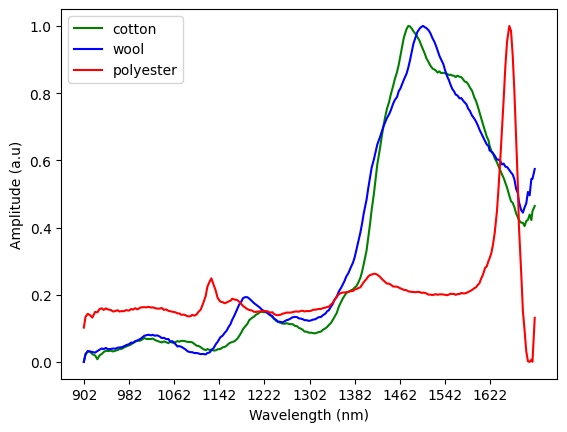

In [ ]:

cotton_portion=data[0:int(np.shape(data)[0]/3)] #900x229; 900 data samples (acq), 0:227 data, 228 label data frame; data --1800x229
wool_portion=data[int(np.shape(data)[0]/3):2*int(np.shape(data)[0]/3)]
polyester_portion=data[2*int(np.shape(data)[0]/3)::]

#normalize spectral data
cp=cotton_portion.iloc[0][0:228]
wp=wool_portion.iloc[0][0:228]
pp=polyester_portion.iloc[0][0:228]

cp_n=(cp-np.min(cp))/(np.max(cp)-np.min(cp))
wp_n=(wp-np.min(wp))/(np.max(wp)-np.min(wp))
pp_n=(pp-np.min(pp))/(np.max(pp)-np.min(pp))

plt.figure(1)
#plt.title('Data')
plt.plot(wavelength[:228], cp_n, 'g', label='cotton') #cotton_portion.iloc[0][0:228]
plt.plot(wavelength[:228], wp_n, 'b', label='wool')
plt.plot(wavelength[:228], pp_n, 'r', label='polyester')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Amplitude (a.u)')
# Change x-axis tick spacing
plt.xticks(np.arange(wavelength[0], wavelength[227], step=80))  # ticks at 0, 2, 4, ..., 10
plt.legend()
plt.show()


In [ ]:
cp=cotton_portion.iloc[0][0:228]
cp_n=(cp-np.mean(cp))/np.std(cp)
cp_n

0     -1.038446
1     -0.965672
2     -0.948475
3     -0.947178
4     -0.968968
         ...   
223    0.224516
224    0.270548
225    0.221626
226    0.300617
227    0.346696
Name: 0, Length: 228, dtype: float64

In [ ]:
# def read_data(path):
#     appended_data = []
#     df = [pd.read_csv(filename,header=21) for filename in glob.glob(path)] 
#     peak_abs=np.zeros((np.shape(df)[0]))
#     for file in range(np.shape(df)[0]):
#         #df[file][['wavelength','absorbance', 'reference', 'sample_signal']]=df[file]['data'].str.split(expand=True)
#         df[file]['wavelength'] = pd.to_numeric(df[file]['Wavelength (nm)'], errors='coerce')
#         df[file]['absorbance'] = pd.to_numeric(df[file]['Absorbance (AU)'], errors='coerce')
#         df[file]['absorbance']=df[file]['absorbance']/np.max(df[file]['absorbance'])
#          # remove data col, as not needed
#         df[file]=df[file].drop(['Absorbance (AU)', 'Reference Signal (unitless)', 'Sample Signal (unitless)', 'Wavelength (nm)'], axis=1)
#         appended_data.append(df[file])
#         peak_abs[file]=df[file]['wavelength'][np.argmax(df[file]['absorbance'])]
#     appended_data = pd.concat(appended_data) # all 900 acquisition appended together
#     #appended_data_coton.to_excel('appended.xlsx') # write to csv    
#     return df, appended_data, peak_abs



# def read_data(path):
#     append_files=[]
#     for file in range(np.shape(df_cotton)[0]):
#         df_cotton[file] = pd.DataFrame(df_cotton[file])
#         #df_cotton[file]=df_cotton[file].drop(['wavelength'], axis=1)
#         append_files_cotton.append(df_cotton[file].T) #228x1
#     append_files_cotton = pd.concat(append_files_cotton) # all 900 acquisition appended together
#     append_files_cotton.to_csv('df_cotton.csv', index=False)




# path_cotton=r'C:\Users\ajitj\OneDrive - Universitetet i Agder\PhD_Research\Paper_Writing\Textile Sorting\Data_textile_NIRSCAN\ML_textile_classification_timeseries\train\cotton\*.csv' # path of file to read
# df_cotton, appended_data_cotton, peak_abs_cotton =read_data(path_cotton) # read file 1000x227x4
# class_cotton=np.zeros(len(appended_data_cotton)).astype(int)
# appended_data_cotton.insert(2, "class", class_cotton)

In [ ]:
# np.shape(df_cotton), np.shape(appended_data_cotton), 

# append_files_cotton=[]
# #convert df_cotton from list to pd dataframe, save it as csv
# for file in range(np.shape(df_cotton)[0]):
#     df_cotton[file] = pd.DataFrame(df_cotton[file])
#     #df_cotton[file]=df_cotton[file].drop(['wavelength'], axis=1)
#     append_files_cotton.append(df_cotton[file].T) #228x1
# append_files_cotton = pd.concat(append_files_cotton) # all 900 acquisition appended together
# append_files_cotton.to_csv('df_cotton.csv', index=False)

 # Use this to read csv files and do ml. Use this ONLY when the data is  saved as .csv

In [ ]:
#use this to read csv files and onwards
data = pd.read_csv(r'samples\data_cotton_wool_polyester.csv')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,class
0,-0.032214,-0.007049,-0.001102,-0.000654,-0.008188,-0.012234,-0.023874,-0.011937,-0.007605,-0.002166,...,0.395435,0.395343,0.384994,0.400474,0.404514,0.420432,0.403515,0.430830,0.446764,0
1,-0.031801,0.001236,0.007400,0.005055,-0.003947,-0.004986,-0.012545,-0.009262,-0.003596,-0.001151,...,0.384945,0.385709,0.380950,0.395877,0.394159,0.409218,0.390902,0.420893,0.425142,0
2,-0.025959,0.004670,0.002298,0.011410,0.001458,-0.006218,-0.008979,-0.002654,0.001702,0.003085,...,0.383040,0.376949,0.388710,0.399407,0.385891,0.400833,0.430223,0.404323,0.440580,0
3,-0.026155,0.001027,0.006856,0.003588,-0.004479,-0.009514,-0.013432,-0.008909,0.001362,-0.001913,...,0.398348,0.387466,0.376672,0.386040,0.408835,0.383884,0.410115,0.420786,0.421234,0
4,-0.034190,-0.003693,-0.006235,-0.003916,-0.014561,-0.015821,-0.016435,-0.017141,-0.007870,-0.003992,...,0.379072,0.376525,0.377253,0.395654,0.380191,0.374733,0.390266,0.373641,0.417048,0


In [ ]:
# train test data set

# train_df, val_df = train_test_split(data, test_size=0.20)
# train_df, test_df = train_test_split(train_df, test_size=0.1)

# #training, val and test data size
# print ("Train shape: {} \n Val shape: {} \n Test shape: {} \n" .format(np.shape(train_df), np.shape(val_df), np.shape(test_df))) 
# #np.array( [np.shape(train_df)[0], np.shape(val_df)[0], np.shape(val_df)[0] ]) /np.array([np.shape(data)[0]])
# # train, val, test - 70, 20, 10

# #save to csv
# #data.to_csv('data_cotton_wool.csv', index=False)  

# #check
# data['class'].value_counts()

In [ ]:
# train, test and split 

y = data['class']
x = data.drop(columns=['class'])
#x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.20,random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=40)


print("Train: \n {}\n".format(y_train.value_counts()))
print("Val: \n {} \n".format(y_val.value_counts()))
print("Test: \n {} \n".format(y_test.value_counts()))

print("Train: \n {} {}\n".format(np.shape(x_train), np.shape(y_train)))
print("Val: \n {} {}\n".format(np.shape(x_val), np.shape(y_val)))
print("Test: \n {} {}\n".format(np.shape(x_test), np.shape(y_test)))

# Train: (1440, 228) (1440,)

#Val: (360, 228) (360,)


Train: 
 class
2    729
3    723
1    718
0    710
Name: count, dtype: int64

Val: 
 class
1    213
0    209
2    194
3    184
Name: count, dtype: int64 

Test: 
 class
3    93
0    81
2    77
1    69
Name: count, dtype: int64 

Train: 
 (2880, 228) (2880,)

Val: 
 (800, 228) (800,)

Test: 
 (320, 228) (320,)



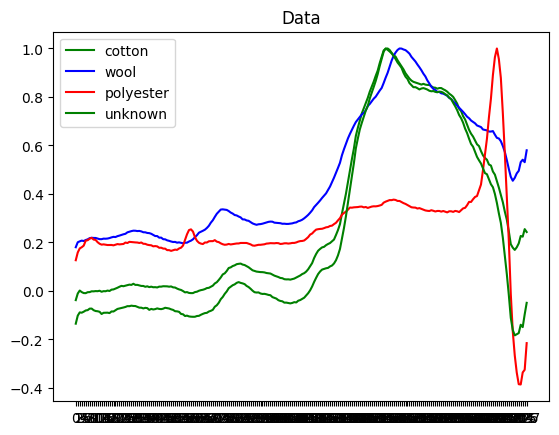

In [ ]:
#check few samples

# find where the label is 0 (cotton) and 1 (wool) in training / val  data
y_train_1=np.argwhere(y_train==1) # index where y_train=1 wool label
y_train_0=np.argwhere(y_train==0) # index where y_train=0 cotton label
y_train_2=np.argwhere(y_train==2) # index where y_train=0 cotton label
y_train_3=np.argwhere(y_train==3) # index where y_train=0 cotton label

y_val_1=np.argwhere(y_val==1) # index where y_val=1 wool label
y_val_0=np.argwhere(y_val==0) # index where y_val=0 cotton label
y_val_2=np.argwhere(y_val==2) # index where y_val=0 cotton label
y_val_3=np.argwhere(y_val==3) # index where y_val=0 cotton label
plt.figure(1)
plt.title('Data')
plt.plot(x_train.iloc[y_train_0[0,0]],'g', label='cotton') #values of absorbance in training data whose label is 0 - cotton
plt.plot(x_train.iloc[y_train_1[0,0]],'b', label='wool') #values of absorbance in training data whose label is 1 - wool
plt.plot(x_train.iloc[y_train_2[0,0]],'r', label='polyester') #values of absorbance in training data whose label is 1 - wool
plt.plot(x_val.iloc[y_train_3[0,0]],'g', label='unknown') #values of absorbance in val data whose label is 0 - cotton
plt.legend()
plt.show()

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS):
  
  # model1 = tf.keras.Sequential([
  #     tf.keras.layers.Dense(
  #         16, activation='relu',
  #         input_shape=(x_train.shape[-1],)),
  #     tf.keras.layers.Dropout(0.5),
  #     tf.keras.layers.Dense(1, activation='sigmoid'),
  # ])

  model=tf.keras.Sequential([
    
  #tf.keras.layers.experimental.preprocessing.Rescaling(scale=1 / 127.5, input_shape=(n_row, n_col, 3), offset=-1),
  #tf.keras.layers.Dense(228, activation='relu',input_shape=(x_train.shape[-1],)),
  tf.keras.layers.Conv1D(8, kernel_size=8, input_shape=(x_train.shape[-1],1), strides=1,  activation='relu'),  
  tf.keras.layers.MaxPooling1D(pool_size=2),
  tf.keras.layers.Conv1D(16, 8, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling1D(pool_size=2),
  
  #tf.keras.layers.Conv1D(32, 8, padding="same", activation="relu"),  !!!!!!
  
  #tf.keras.layers.Conv1D(64, 3, padding="same", activation="relu"),
  #tf.keras.layers.MaxPooling1D(pool_size=2),
  #tf.keras.layers.Conv1D(64, 3, padding="same", activation="relu"),
  #tf.keras.layers.MaxPooling1D(pool_size=2),

  #tf.keras.layers.Conv1D(64, 3, activity_regularizer=tf.keras.regularizers.L2(0.01),padding="same", activation="relu"),
  tf.keras.layers.MaxPooling1D(pool_size=2),

  tf.keras.layers.Flatten(),

  # tf.keras.layers.Dense(64, 
  # activity_regularizer=tf.keras.regularizers.L2(0.01),
  # activation='relu'),

  tf.keras.layers.Dense(
     32, 
      activity_regularizer=tf.keras.regularizers.L2(0.01),
      activation='relu'),
  tf.keras.layers.Dropout(0.2),
  #tf.keras.layers.Dense(1, activation='sigmoid'),
  tf.keras.layers.Dense(3, activation='softmax'),
    ])

  model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # use false when we have softmax at last layer
        metrics=metrics)

  return model

EPOCHS = 100 #50
BATCH_SIZE = 32

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_prc', 
#     verbose=1,
#     patience=10,
#     mode='max',
#     restore_best_weights=True)

model = make_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 221, 8)            72        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 110, 8)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 110, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 16)           0         
 1D)                                                             
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 27, 16)           0         
 1D)                                                             
                                                        

In [ ]:
import tempfile
import datetime
import os
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Define the model save path
log_path = r'C:\Users\chaba\OneDrive\Skrivebord\MAS513_local\Textile_sorting\Project\textile_sorting_NIRSCAN_\scripts\model'

# Generate a timestamp for model naming
ap_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_save_path = os.path.join(log_path, f"trained_model_{ap_name}.h5")

# Define TensorBoard log directory
log_dir = os.path.join(log_path, f"logs_{ap_name}")

# TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=False,
    write_images=False,
    update_freq='epoch',  # Frequency of updates
    profile_batch=0,
    embeddings_freq=0
)

# One-hot encoding for target variables
enc = OneHotEncoder()
y_train_ohe = enc.fit_transform(np.asarray(y_train).astype('float32').reshape((-1, 1))).toarray()
y_val_ohe = enc.fit_transform(np.asarray(y_val).astype('float32').reshape((-1, 1))).toarray()
y_test_ohe = enc.fit_transform(np.asarray(y_test).astype('float32').reshape((-1, 1))).toarray()

# Train the model
history = model.fit(
    x_train,
    y_train_ohe,
    validation_data=(x_val, y_val_ohe),
    epochs=EPOCHS,
    verbose=1,
    callbacks=[tensorboard_callback]
)

# Save the trained model
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")


Epoch 1/100


ValueError: in user code:

    File "c:\Users\chaba\OneDrive\Skrivebord\MAS512_local\python_venvs\MAS512_G_2024_AUTUMN\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\chaba\OneDrive\Skrivebord\MAS512_local\python_venvs\MAS512_G_2024_AUTUMN\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\chaba\OneDrive\Skrivebord\MAS512_local\python_venvs\MAS512_G_2024_AUTUMN\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\chaba\OneDrive\Skrivebord\MAS512_local\python_venvs\MAS512_G_2024_AUTUMN\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\chaba\OneDrive\Skrivebord\MAS512_local\python_venvs\MAS512_G_2024_AUTUMN\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\chaba\OneDrive\Skrivebord\MAS512_local\python_venvs\MAS512_G_2024_AUTUMN\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\chaba\OneDrive\Skrivebord\MAS512_local\python_venvs\MAS512_G_2024_AUTUMN\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\chaba\OneDrive\Skrivebord\MAS512_local\python_venvs\MAS512_G_2024_AUTUMN\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\chaba\OneDrive\Skrivebord\MAS512_local\python_venvs\MAS512_G_2024_AUTUMN\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\chaba\OneDrive\Skrivebord\MAS512_local\python_venvs\MAS512_G_2024_AUTUMN\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((32, 3) vs (32, 4)).


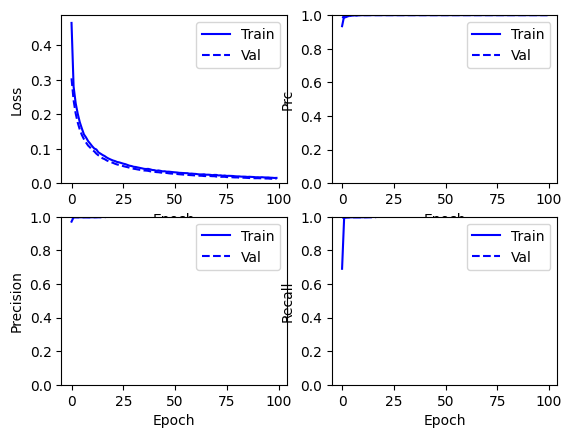

In [ ]:
#plot training history

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  colors=['b', 'g']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

In [ ]:
#confusion matrix


test_predictions_baseline = model.predict(x_test, batch_size=BATCH_SIZE)
class_names=['Cotton', 'Wool', 'Polyester', 'Unknown']
threshold=0.8

def plot_cm(labels, predictions, class_names, threshold):
  predictions > threshold
  np.argmax(predictions, axis=1)
  predicted_label=np.argmax(predictions, axis=1)
  
  cm = confusion_matrix(labels,predicted_label ) #predictions > threshold
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #normalized cm
  
  plt.figure(figsize=(5,5))
  #sns.heatmap(cm, annot=True, fmt="d")
  #plt.subplot(2,1,1)
  #sns.heatmap(cmn, annot=True, fmt=".2f", xticklabels=class_names, yticklabels=class_names) 
 
  # plt.subplot(2,1,2)
  sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
  
  plt.title('Confusion matrix (Test Data set) @ {:.2f} threshold'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

  print('Classification report : \n',classification_report(y_test, predicted_label, target_names=class_names)) #true_label, predicted_label

baseline_results = model.evaluate(x_val, y_val_ohe,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline, class_names, threshold)



NameError: name 'model' is not defined

In [ ]:
#np.shape(x_test)
x_test_arr=np.array(x_test)
np.shape(x_test_arr)
test_predictions_baseline1 = model.predict(x_test_arr[np.random.randint(len(x_test_arr))].reshape(1, -1))
print(test_predictions_baseline1)
aa=np.argmax(test_predictions_baseline1)
'''
# Define the server IP and port (use the Ubuntu machine's IP)
SERVER_IP = '192.168.1.20'
SERVER_PORT = 12345

# Create a socket object
client_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

# Connect to the server
client_socket.connect((SERVER_IP, SERVER_PORT))

# Send the detection label to the server
client_socket.send(str(aa).encode('utf-8'))
print(f"Sent label: {aa}")

# Close the connection
client_socket.close()
'''

1/1 [==============================] - 0s 183ms/step
[[9.9998939e-01 5.0955719e-06 5.4782427e-06]]


'\n# Define the server IP and port (use the Ubuntu machine\'s IP)\nSERVER_IP = \'192.168.1.20\'\nSERVER_PORT = 12345\n\n# Create a socket object\nclient_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)\n\n# Connect to the server\nclient_socket.connect((SERVER_IP, SERVER_PORT))\n\n# Send the detection label to the server\nclient_socket.send(str(aa).encode(\'utf-8\'))\nprint(f"Sent label: {aa}")\n\n# Close the connection\nclient_socket.close()\n'